# Problem 3: Google Playstore Apps Dataset

This notebook processes the "GooglePlaystore.xlsx" file to perform the following tasks:

1. Preprocessing (28 pts)
   - Remove the outlier in the 'Reviews' column where the value is "3.0M".
   - Replace "Varies with device" with NA in all columns and drop those rows.
   - Clean the 'Android Ver' column: remove trailing text (e.g., "and up"), extract only the first part of a range and limit the version to the first two components.
   - Process the 'Installs' column: remove commas and '+' characters, ensure only numeric rows remain, and convert to integer.
   - Process 'Reviews' and 'Rating': convert 'Reviews' to integers and 'Rating' to numeric; drop rows with missing Rating if Reviews < 100 and Installs < 50,000, otherwise fill missing Rating with the average of that Category.
   - Process the 'Size' column: convert size values containing "K" or "M" to integers.

2. Analysis (19 pts)
   - Display category-wise rating statistics using the `describe` method.
   - Extract all Free apps and create a function that returns the top 3 apps per Category based on a given numeric metric (Rating, Installs, or Reviews). The resulting DataFrame should include the columns: Category, App, and the specified metric.
   - For Paid apps, remove the '$' symbol and calculate the average, maximum, and minimum prices.

3. Visualization (16 pts)
   - Split the 'Genres' column by ";" into a list, explode the column, count the number of apps per genre, and display the top 10 genres as a pie chart.
   - Create a box plot comparing the Rating distributions for the Business and Education categories.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the Excel file (assumed to be in the same folder)
google_df = pd.read_excel('GooglePlaystore.xlsx')

## 1. Remove Outlier in 'Reviews'

Remove the row where the 'Reviews' column is "3.0M".

In [2]:
google_df = google_df[google_df['Reviews'] != '3.0M']

## 2. Remove Rows with "Varies with device"

Replace any occurrence of "Varies with device" with NA and drop those rows.

In [3]:
google_df = google_df.replace("Varies with device", pd.NA)
google_df = google_df.dropna()

/tmp/ipykernel_1690638/2260338183.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  google_df = google_df.replace("Varies with device", pd.NA)


## 3. Clean 'Android Ver' Column

Clean the 'Android Ver' column by:
- Splitting if a range exists (take only the first value).
- Removing "and up" and extra spaces.
- Keeping only the first two components of the version number.

In [4]:
def clean_android_ver(val):
    if '-' in val:
        val = val.split('-')[0].strip()
    val = val.replace('and up', '').strip()
    parts = val.split('.')
    return '.'.join(parts[:2])

# Use the working column name "Android Ver"
google_df['Android Ver'] = google_df['Android Ver'].apply(clean_android_ver)

## 4. Process 'Installs' Column

Clean the 'Installs' column by removing commas and '+' characters, ensure only numeric rows remain, and convert values to integers.

In [5]:
google_df['Installs'] = google_df['Installs'].str.replace('[+,]', '', regex=True)
google_df = google_df[google_df['Installs'].str.isnumeric()]
google_df['Installs'] = google_df['Installs'].astype(int)

## 5. Process 'Reviews' and 'Rating' Columns

Convert 'Reviews' to integers and 'Rating' to numeric values.  
For rows with missing 'Rating', if Reviews < 100 and Installs < 50,000, drop the row; otherwise, fill missing 'Rating' with the Category's average rating (rounded to 2 decimals).

In [6]:
google_df['Reviews'] = google_df['Reviews'].astype(int)
google_df['Rating'] = pd.to_numeric(google_df['Rating'], errors='coerce')
condition = (google_df['Reviews'] < 100) & (google_df['Installs'] < 50000)
google_df = google_df[~((google_df['Rating'].isna()) & condition)]
google_df['Rating'] = google_df.groupby('Category')['Rating']\
                               .transform(lambda x: x.fillna(round(x.mean(), 2)))

## 6. Process 'Size' Column

Convert the 'Size' column values that contain "K" (thousands) or "M" (millions) into integers. For example, "8.7M" should become 8700000.

In [7]:
def convert_size(val):
    val = val.upper().replace(',', '').strip()
    if 'K' in val:
        return int(float(val.replace('K','')) * 1000)
    elif 'M' in val:
        return int(float(val.replace('M','')) * 1000000)
    else:
        try:
            return int(float(val))
        except:
            return pd.NA

google_df['Size'] = google_df['Size'].apply(convert_size)
google_df = google_df.dropna(subset=['Size'])

## 7. Category-wise Rating Statistics

Display descriptive statistics (using `describe`) for the 'Rating' column of each Category.

In [8]:
rating_stats = google_df.groupby('Category')['Rating'].describe()
print("Rating statistics by Category:")
print(rating_stats)

Rating statistics by Category:
                      count      mean       std  min    25%   50%    75%  max
Category                                                                     
ART_AND_DESIGN         57.0  4.378947  0.337394  3.4  4.100  4.40  4.700  5.0
AUTO_AND_VEHICLES      62.0  4.146774  0.569935  2.1  3.900  4.25  4.500  4.9
BEAUTY                 37.0  4.291892  0.370719  3.1  4.000  4.30  4.600  4.9
BOOKS_AND_REFERENCE   144.0  4.320139  0.457812  2.7  4.100  4.40  4.625  5.0
BUSINESS              245.0  4.119184  0.663942  1.0  3.800  4.30  4.500  5.0
COMICS                 48.0  4.154167  0.556187  2.8  3.775  4.40  4.600  5.0
COMMUNICATION         209.0  4.100957  0.503831  1.0  3.900  4.20  4.400  5.0
DATING                173.0  3.957803  0.666132  1.0  3.600  4.10  4.400  5.0
EDUCATION             109.0  4.392661  0.255570  3.5  4.300  4.40  4.600  4.9
ENTERTAINMENT          86.0  4.145349  0.291308  3.0  4.000  4.20  4.300  4.7
EVENTS                 35.0  4.47

## 8. Top 3 Free Apps per Category

Extract all Free apps and define a function that returns the top 3 apps per Category for a given numeric metric (Rating, Installs, or Reviews).
The result should include the columns: Category, App, and the specified metric.

In [9]:
free_apps = google_df[google_df['Type'] == 'Free']

def top3_by(metric):
    return (free_apps.sort_values(metric, ascending=False)
            .groupby('Category')
            .head(3)[['Category', 'App', metric]])

print("Top 3 Free Apps by Rating (sample):")
print(top3_by('Rating').head(10))
print("\nTop 3 Free Apps by Installs (sample):")
print(top3_by('Installs').head(10))
print("\nTop 3 Free Apps by Reviews (sample):")
print(top3_by('Reviews').head(10))

Top 3 Free Apps by Rating (sample):
                 Category                               App  Rating
10837              FAMILY  Fr. Mike Schmitz Audio Teachings     5.0
6823               FAMILY    Barisal University App-BU Face     5.0
6807                TOOLS                         Jabbla BT     5.0
6783               FAMILY                   Wifi BT Scanner     5.0
1038               EVENTS         Mindvalley U Tallinn 2018     5.0
6727        COMMUNICATION                         BS-Mobile     5.0
1030               EVENTS                        Prosperity     5.0
6700                 GAME                  Brick Breaker BR     5.0
10266  NEWS_AND_MAGAZINES             Noticias FC Barcelona     5.0
1028               EVENTS                  SUMMER SONIC app     5.0

Top 3 Free Apps by Installs (sample):
                Category                                          App  \
1750                GAME                               Subway Surfers   
3736  NEWS_AND_MAGAZINES       

## 9. Price Analysis for Paid Applications

For Paid apps, convert the 'Price' column to numeric values (by removing the '$' symbol) and calculate the average, maximum, and minimum prices.

In [10]:
paid_apps = google_df[google_df['Type'] == 'Paid'].copy()
paid_apps['Price'] = paid_apps['Price'].astype(str).str.replace('$', '').astype(float)
avg_price = paid_apps['Price'].mean()
max_price = paid_apps['Price'].max()
min_price = paid_apps['Price'].min()
print("\nPaid Apps Price Statistics:")
print("Average Price:", avg_price, "Max Price:", max_price, "Min Price:", min_price)


Paid Apps Price Statistics:
Average Price: 15.199492119089317 Max Price: 400.0 Min Price: 0.99


## 10. Genre Distribution Pie Chart

Split the 'Genres' column by ';' into a list, explode it to obtain individual genres, count the number of apps for each genre, and display the top 10 genres as a pie chart.

In [ ]:
google_df['Genres'] = google_df['Genres'].str.split(';')
genre_df = google_df.explode('Genres')
genre_counts = genre_df['Genres'].value_counts()

plt.figure(figsize=(8,8))
genre_counts.head(10).plot(kind='pie', autopct='%1.1f%%')
plt.ylabel('')
plt.title('Top 10 Genres Distribution')
plt.show()

## 11. Box Plot for Business vs Education

Create a box plot to compare the distribution of 'Rating' for apps in the 'BUSINESS' and 'EDUCATION' categories.

/tmp/ipykernel_1690638/1849736568.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['BUSINESS', 'EDUCATION'])


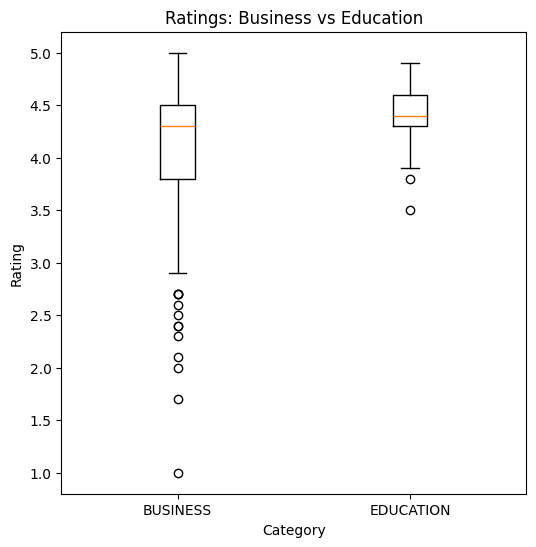

In [12]:
subset = google_df[google_df['Category'].isin(['BUSINESS', 'EDUCATION'])]
plt.figure(figsize=(6,6))
# Prepare data for box plot: list of 'Rating' values for each category
data = [subset[subset['Category'] == cat]['Rating'] for cat in ['BUSINESS', 'EDUCATION']]
plt.boxplot(data, tick_labels=['BUSINESS', 'EDUCATION'])
plt.title('Ratings: Business vs Education')
plt.xlabel('Category')
plt.ylabel('Rating')
plt.show()